# Training a CNN model for Object Recognition


We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [1]:
# ---------------------------------------------------------------------------- #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 20
learning_rate = 0.001
batch_size = 100

## Load CIFAR10 Dataset

In [3]:
# Image preprocessing modules
transform = transforms.Compose([transforms.Pad(4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32),
                                transforms.ToTensor()])


# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Display some of the training images

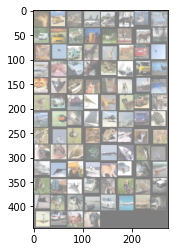

 bird truck  frog plane horse horse  ship   car truck   car  bird truck  deer horse horse  ship   cat plane truck horse   cat horse   car plane plane horse   car  deer  frog truck truck  deer   cat plane  ship   cat   cat   dog  ship plane  bird   car truck  bird plane   dog truck   cat plane  bird  bird  ship plane truck truck  frog  frog  ship  bird  frog  frog  ship   cat  deer   cat   cat  bird  frog  ship  ship   cat  bird plane plane truck  ship   cat   car   cat  ship  deer truck plane truck   cat  bird  bird   car   cat horse   dog  ship   car plane plane truck plane   car horse   dog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Define a Convolutional Neural Network

In [5]:
### Residual Network

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [10]:
model_name = 'resnet_relu_fn'
model = ResNet(ResidualBlock, [2, 2, 2,2]).to(device)

## Define a Loss function, optimizer and learning rate shedular

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Train the network

In [12]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/20], Step [100/500] Loss: 1.7356
Epoch [1/20], Step [200/500] Loss: 1.6190
Epoch [1/20], Step [300/500] Loss: 1.2700
Epoch [1/20], Step [400/500] Loss: 1.3379
Epoch [1/20], Step [500/500] Loss: 1.1081
Epoch [2/20], Step [100/500] Loss: 1.1372
Epoch [2/20], Step [200/500] Loss: 0.9641
Epoch [2/20], Step [300/500] Loss: 1.1327
Epoch [2/20], Step [400/500] Loss: 0.8380
Epoch [2/20], Step [500/500] Loss: 0.9971
Epoch [3/20], Step [100/500] Loss: 0.9227
Epoch [3/20], Step [200/500] Loss: 0.9693
Epoch [3/20], Step [300/500] Loss: 0.7921
Epoch [3/20], Step [400/500] Loss: 0.8449
Epoch [3/20], Step [500/500] Loss: 0.8563
Epoch [4/20], Step [100/500] Loss: 0.7832
Epoch [4/20], Step [200/500] Loss: 0.6901
Epoch [4/20], Step [300/500] Loss: 0.6177
Epoch [4/20], Step [400/500] Loss: 0.6224
Epoch [4/20], Step [500/500] Loss: 0.6786
Epoch [5/20], Step [100/500] Loss: 0.8759
Epoch [5/20], Step [200/500] Loss: 0.6582
Epoch [5/20], Step [300/500] Loss: 0.6033
Epoch [5/20], Step [400/500] Loss:

## Test the network on the test data

In [15]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), model_name + '.ckpt')

Accuracy of the model on the test images: 84.23 %


In [16]:
PATH = './' + model_name + '.ckpt'
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 88.6 %
Accuracy for class car   is: 93.7 %
Accuracy for class bird  is: 76.7 %
Accuracy for class cat   is: 72.5 %
Accuracy for class deer  is: 71.1 %
Accuracy for class dog   is: 75.6 %
Accuracy for class frog  is: 91.1 %
Accuracy for class horse is: 90.7 %
Accuracy for class ship  is: 88.0 %
Accuracy for class truck is: 94.3 %
